# Empirically Matching OM10 Lens Galaxies to SL2S

_Phil Marshall & Bryce Kalmbach, September 2016_

_Last Updated: Bryce Kalmbach, September 2018_

We need to be able to assign a stellar mass and size to each of our OM10 lens galaxies, so that we can, in turn, associate a suitable `cosmoDC2` galaxy with that object. To do this, we will follow Tom Holoien's "empiriciSN" approach, and model the intrinsic distribution of lens galaxy size, stellar mass, redshift and velocity dispersion with the "extreme deconvolution" algorithm.

SEDs will need to be matched in a separate code since `gcr-catalogs` does not have SEDs in the available as the old CATSIM galaxies did.


## Requirements

You will need to have installed Tom Holoien's [`XDGMM`]() and [`empiriciSN`]() packages, as well as their dependencies. 

> By default, in `empiricSN` all the model fitting is done with the [`AstroML`](http://www.astroml.org/index.html) XDGMM algorithm rather than the [Bovy et al. (2011)](https://github.com/jobovy/extreme-deconvolution) algorithm - for this demo you do not need to have the Bovy et al. algorithm installed to run the code. However, we note that the Bovy et al. algorithm is, in general, significantly (i.e., several times) faster. We recommend you try each method on your dataset when using this class.

In [1]:
import numpy as np
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
import corner
import urllib
import os
from sklearn.cross_validation import train_test_split
from astroML.plotting import setup_text_plots

import empiriciSN
from MatchingLensGalaxies_utilities import *
%matplotlib inline

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Empirical Strong Lens Data

We'll use the SL2S sample of galaxy-scale lenses to model the properties of OM10 lenses. The redshifts and velocity dispersions should cover *most* (but not all) of the LSST lensed quasar sample in OM10.

The data is in Table 3 of [Sonnenfeld et al (2013)](https://arxiv.org/abs/1307.4759), and stored as a csv format file in the Twinkles data folder.

In [2]:
def get_sl2s_data():
    filename = '../../data/SonnenfeldEtal2013_Table3.csv'
    ! wc -l $filename

    z = np.array([])
    z_err = np.array([])
    v_disp = np.array([])
    v_disp_err = np.array([])
    r_eff = np.array([])
    r_eff_err = np.array([])
    log_m = np.array([])
    log_m_err = np.array([])
    
    infile = open(filename, 'r')
    inlines = infile.readlines()
    
    for line1 in inlines:
        if line1[0] == '#': continue
        line = line1.split(',')
        
        #Params
        z = np.append(z, float(line[1]))
        v_disp = np.append(v_disp, float(line[2]))
        r_eff = np.append(r_eff, float(line[3]))
        log_m = np.append(log_m, float(line[4]))
        
        #Errors
        z_err = np.append(z_err, float(line[5]))
        v_disp_err = np.append(v_disp_err, float(line[6]))
        r_eff_err = np.append(r_eff_err, float(line[7]))
        log_m_err = np.append(log_m_err, float(line[8]))
    
    #Build final arrays
    X = np.vstack([z, v_disp, r_eff, log_m]).T
    Xerr = np.zeros(X.shape + X.shape[-1:])
    diag = np.arange(X.shape[-1])
    
    Xerr[:, diag, diag] = np.vstack([z_err**2, v_disp_err**2,
                                    r_eff_err**2, log_m_err**2]).T
    
    return X, Xerr

# Here's what we did to get the csv file:
# ! echo "ID, zlens, vdisp, Reff, Mstar, zlens_err, vdisp_err, Reff_err, Mstar_err" > SonnenfeldEtal2013_Table3.csv  
# ! cat gammaptable.tex | sed s%'&'%%g | sed s%'\$'%%g | sed s%'\\'%%g | sed s%'pm'%'  '%g | sed s%'disky'%%g | awk '{print $1", "$2", "$5", "$3", "$7", 0.001, "$6", 0.01, "$8}' >> SonnenfeldEtal2013_Table3.csv

## Component Test

We could fit our lens galaxy dataset directly, but one problem is that we don't know the optimal number of components (Gaussians) to use in the fit. Knowing the optimal number of components to fit allows us to obtain a good fit in the smallest amount of time without overfitting the data.

### BIC
One way to determine the optimal number of Gaussian components to use in the model is by fitting the model with different numbers of components and calculating the Bayesian information criterion (BIC) for each model. The BIC incorporates the number of components in the model, the sample size, and the likelihood of the data under the model, and the model with the lowest score is the optimal model to use.

We can test for the model with the lowest BIC score for a given dataset using the `component_test` function, which will compute the BIC for a given dataset and range of n_components and return an array containing all the BIC scores as well as the optimal number of components and corresponding BIC value. The code below will read in all the SN and host parameters we want to use from our data files (using the `get_data` function) and use these data to test the performance of the model with n_components ranging from 1 to 8. (Larger numbers of components tend to run into errors occurring because too few observations map to a given Gaussian component. With a bigger dataset, this range could be increased.)

<Note that due to the multiple fits and the large dataset, the BIC test will likely take a while to run, depending on your system.>

In [3]:
# Instantiate an empiriciSN worker object:
empiricist = empiriciSN.Empiricist()

In [4]:
# Define the range of component numbers and read in the dataset:
component_range = np.array([1,2,3,4,5,6,7,8])
X, Xerr = get_sl2s_data()

26 ../../data/SonnenfeldEtal2013_Table3.csv


In [5]:
%%capture --no-stdout
# Loop over component numbers, fitting XDGMM model and computing the BIC. 

bics, optimal_n_comp, lowest_bic = empiricist.component_test(X, Xerr, component_range)

N = 1 , BIC = 404.677168861
N = 2 , BIC = 410.426768575
N = 3 , BIC = 442.266672909
N = 4 , BIC = 453.721342968
N = 5 , BIC = 482.676598861
N = 6 , BIC = 513.756618936
N = 7 , BIC = 516.102288146
N = 8 , BIC = 565.408009167


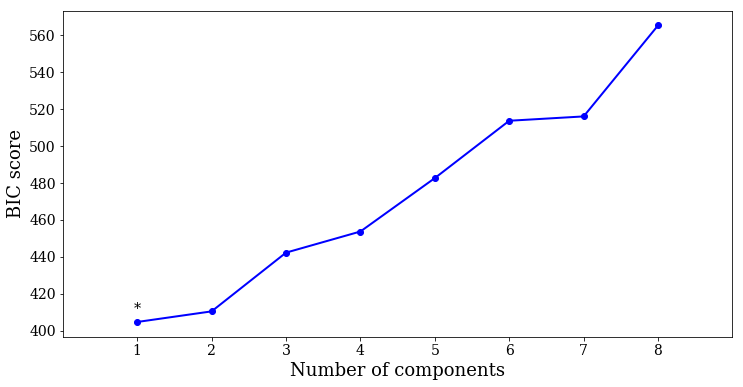

In [6]:
plot_bic(component_range, bics, optimal_n_comp)

> Based on the results of the above test, the model with 1 component has the lowest BIC score and is the optimal choice.


## Fitting a Model

Once we know how many components to use in the model, we can fit a model using that number of components using the `fit_model` function. Before fitting for this demo, we are going to split our lens galaxy dataset 65-35, with the larger subsample being used to fit the model and the smaller subsample providing a test sample that we can use to predict stellar masses and compare with our predicted sample.

In [7]:
%%capture --no-stdout
# Split the dataset 65/35:
X_train, X_test, Xerr_train, Xerr_test = \
    train_test_split(X, Xerr, test_size=0.35, random_state=17)

# Fit the model:
empiricist.fit_model(X_train, Xerr_train, filename = 'demo_model.fit', n_components=1)
#empiricist.read_model('demo_model.fit')

Note how the `fit_model` function also saves the fit to a file for later re-use. If a model has already been fit, it can be read into an existing `Empiricist` worker, or a new `Empiricist` can be instantiated using the model, like this:

In [8]:
alternative = empiriciSN.Empiricist(model_file='demo_model.fit')

# Print the weights array for each object---they should be the same...
print(empiricist.XDGMM.weights)
print(alternative.XDGMM.weights)

[ 1.]
[ 1.]


## Predicting stellar masses of lens galaxies

Our goal in this notebook is to predict the stellar masses of OM10 lens galaxies. Here we use the XDGMM model we just fit on the test data we separated off from the full dataset. We will use the model to predict stellar masses of lens galaxies based upon their redshift, velocity dispersion and radial size.

<The "test" sample generated above gives us a set of 482 host properties that we can use to fit supernovae, and a set of supernova properties to compare with our model fits.>

First, we adapt the "get_logR" function from empiriciSN to "get_log_m" changing the references and restrictions of that method (it only allows certain columns due to structure of SN dataset it uses) to suit our strong lensing dataset.

In [9]:
#Write new conditioning function
def get_log_m(cond_indices, m_index, X, model_file, Xerr=None):
    
    """
        Uses a subset of parameters in the given data to condition the
        model and return a sample value for log(M/M_sun).

        Parameters
        ----------
        cond_indices: array_like
            Array of indices indicating which parameters to use to
            condition the model. 
        m_index: int
            Index of log(M/M_sun) in the list of parameters that were used
            to fit the model.
        X: array_like, shape = (n < n_features,)
            Input data.
        Xerr: array_like, shape = (X.shape,) (optional)
            Error on input data. If none, no error used to condition.

        Returns
        -------
        log_m: float
            Sample value of log(M/M_sun) taken from the conditioned model.

        Notes
        -----
        The fit_params array specifies a list of indices to use to
        condition the model. The model will be conditioned and then
        a mass will be drawn from the conditioned model.

        This is so that the mass can be used to find cosmoDC2 galaxies
        to act as hosts for OM10 systems.

        This does not make assumptions about what parameters are being
        used in the model, but does assume that the model has been
        fit already.
    """

    if m_index in cond_indices:
        raise ValueError("Cannot condition model on log(M/M_sun).")

    cond_data = np.array([])
    if Xerr is not None: cond_err = np.array([])
    m_cond_idx = m_index
    n_features = empiricist.XDGMM.mu.shape[1]
    j = 0

    for i in range(n_features):
        if i in cond_indices:
            cond_data = np.append(cond_data,X[j])
            if Xerr is not None: cond_err = np.append(cond_err, Xerr[j])
            j += 1
            if i < m_index: m_cond_idx -= 1
        else:
            cond_data = np.append(cond_data,np.nan)
            if Xerr is not None: cond_err = np.append(cond_err, 0.0)

    if Xerr is not None:
        cond_XDGMM = empiricist.XDGMM.condition(cond_data, cond_err)
    else: cond_XDGMM = empiricist.XDGMM.condition(cond_data)

    sample = cond_XDGMM.sample()
    log_m = sample[0][m_cond_idx]
    return log_m

With that ready to go, we now use it to get estimates on the stellar mass of our test data from the model we have trained above.

In [10]:
%%capture --no-stdout
# Get actual masses from dataset, for comparison:
log_m_test = X_test[:,3]
r_test = X_test[:,2]

# Predict a mass for each galaxy:
np.random.seed(0)
cond_indices = np.array([0,1])
sample_log_m = np.array([])
sample_r = np.array([])

model_file='demo_model.fit'

for x, xerr in zip(X_test, Xerr_test):
    log_m = get_log_m(cond_indices, 3, x[cond_indices], model_file)#, Xerr=xerr)
    sample_log_m = np.append(sample_log_m,log_m)
    print(x[3], log_m)
    
for x, xerr in zip(X_test, Xerr_test):
    r_cond = get_log_m(cond_indices, 2, x[cond_indices], model_file)#, Xerr=xerr)
    sample_r = np.append(sample_r,r_cond)
    print(x[2], r_cond)

11.76 11.331095751
11.45 11.4383623875
11.6 11.472890811
11.28 11.1648297715
11.81 11.2007569882
11.14 11.4886673289
11.26 11.4436672157
11.51 12.2439183667
11.53 11.7600296547
7.86 6.25885282711
8.92 8.05264143642
4.35 13.7363710186
3.04 3.37140361718
8.59 4.61904829769
1.35 0.586960021396
3.86 7.39634635567
3.93 7.89501023704
4.27 12.8430002306


Now we have a set of test masses in units of log(M/M_sun) and a set of masses sampled from the model. These should have the same distribution when plotted.

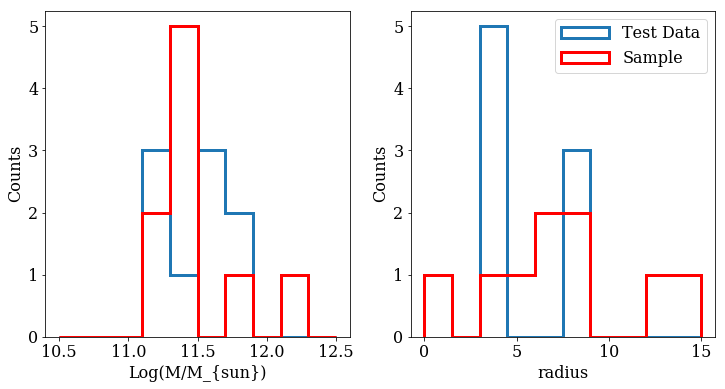

In [11]:
fig = plt.figure(figsize=(12,6))

fig.add_subplot(121)
plt.hist(log_m_test, 10, range=(10.5, 12.5), histtype='step', lw=3)
plt.hist(sample_log_m, 10, range=(10.5, 12.5), color ='r', histtype='step', lw=3)
plt.xlabel('Log(M/M_{sun})')
plt.ylabel('Counts')

fig.add_subplot(122)
plt.hist(r_test, 10, range=(0, 15), histtype='step', lw=3)
plt.hist(sample_r, 10, range=(0, 15), color ='r', histtype='step', lw=3)
plt.xlabel('radius')
plt.ylabel('Counts')
plt.legend(('Test Data', 'Sample'))
plt.show()

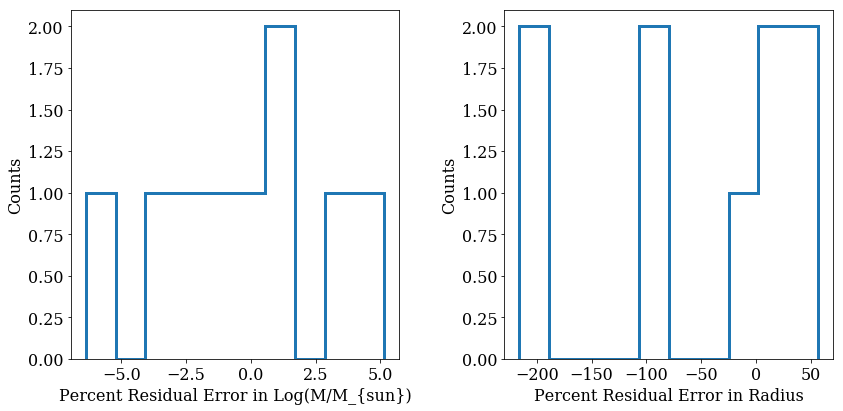

In [12]:
fig = plt.figure(figsize=(12,6))

fig.add_subplot(121)
plt.hist(100*(log_m_test-sample_log_m)/log_m_test, 10, histtype='step', lw=3)
plt.xlabel('Percent Residual Error in Log(M/M_{sun})')
plt.ylabel('Counts')

fig.add_subplot(122)
plt.hist(100*(r_test-sample_r)/r_test, 10, histtype='step', lw=3)
plt.xlabel('Percent Residual Error in Radius')
plt.ylabel('Counts')
plt.tight_layout()

It seems that while we can predict the stellar masses to a reasonable degree the estimates for Radius are very poor and we should get those values from cosmoDC2 while matching galaxies on just stellar mass, redshift and ellipticity. Furthermore, below we will drop the radius from the model.

The dataset has a very small amount of data and to prevent overfitting against an even smaller sample we choose to use the full dataset in training the model going forward. We want to make sure that the model gives reasonable values when generating masses, redshift and velocity dispersions. Therefore, we will sample the GMM for 1, 2 and 3 component models and take a look at the results with the training data.

In [13]:
# Drop the radius data and fit only to predict stellar mass
X = X[:,[0,1,3]]
Xerr = Xerr[:,:,[0,1,3]]
Xerr = Xerr[:,[0,1,3], :]

In [14]:
%%capture --no-stdout
empiricist.fit_model(X, Xerr, filename = 'demo_model.fit', n_components=1)
test_sample = empiricist.XDGMM.sample(size=10000)

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))


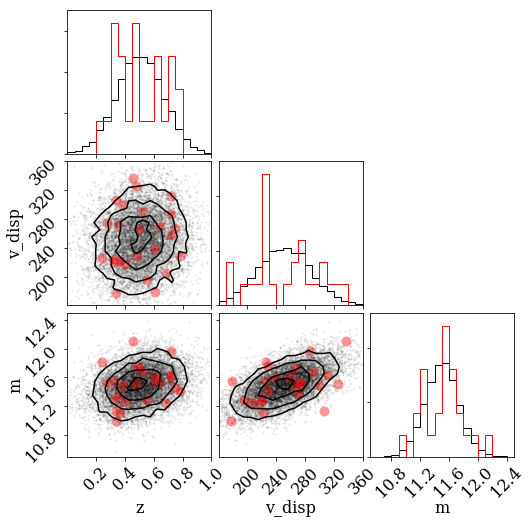

In [15]:
setup_text_plots(fontsize=16, usetex=False)
mpl.rcParams['text.usetex'] = False

figure = corner.corner(test_sample[:,:], labels=['z', 'v_disp', 'm'], 
                       range = [(0.0, 1.0), (160, 360), (10.5, 12.5)],
              hist_kwargs = {'normed': True}, no_fill_contours=True, 
              plot_density=False)

corner.corner(X[:, :], labels=['z', 'v_disp', 'm'], color='red', 
              range = [(0.0, 1.0), (160, 360), (10.5, 12.5)],
              hist_kwargs = {'normed':True}, plot_contours=False, 
              plot_density=False, plot_datapoints=True, 
              data_kwargs={'marker':'o', 'alpha':0.4, 'markersize':10}, 
              fig=figure)

plt.show()

Here we try fitting our model with 2 components in the GMM.

In [16]:
%%capture --no-stdout
empiricist.fit_model(X, Xerr, filename = 'demo_model.fit', n_components=2)

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))


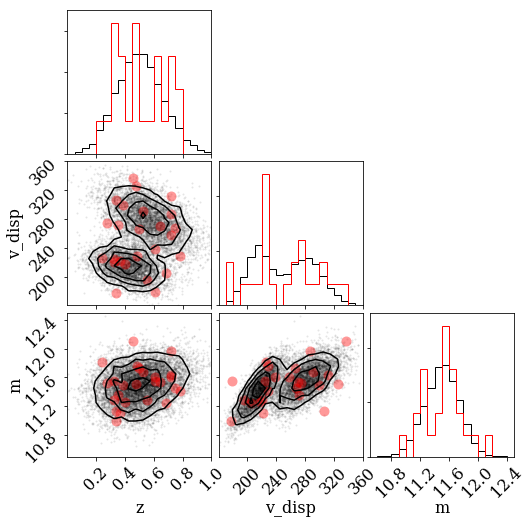

In [17]:
test_sample = empiricist.XDGMM.sample(size=10000)
setup_text_plots(fontsize=16, usetex=False)
mpl.rcParams['text.usetex'] = False

figure = corner.corner(test_sample[:,:], labels=['z', 'v_disp', 'm'], 
                       range = [(0.0, 1.0), (160, 360), (10.5, 12.5)],
              hist_kwargs = {'normed': True}, no_fill_contours=True, 
              plot_density=False)

corner.corner(X[:, :], labels=['z', 'v_disp', 'm'], color='red', 
              range = [(0.0, 1.0), (160, 360), (10.5, 12.5)],
              hist_kwargs = {'normed':True}, plot_contours=False, 
              plot_density=False, plot_datapoints=True, 
              data_kwargs={'marker':'o', 'alpha':0.4, 'markersize':10}, 
              fig=figure)

plt.show()

And here we use 3 components.

In [18]:
%%capture --no-stdout
empiricist.fit_model(X, Xerr, filename = 'demo_model.fit', n_components=3)

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))


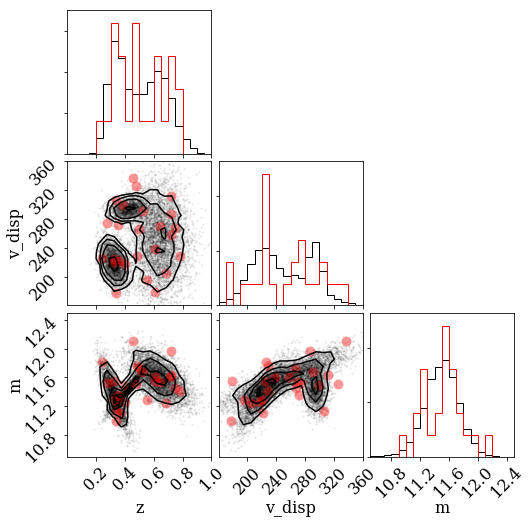

In [19]:
test_sample = empiricist.XDGMM.sample(size=10000)
setup_text_plots(fontsize=16, usetex=False)
mpl.rcParams['text.usetex'] = False

figure = corner.corner(test_sample[:,:], labels=['z', 'v_disp', 'm'], 
                       range = [(0.0, 1.0), (160, 360), (10.5, 12.5)],
              hist_kwargs = {'normed': True}, no_fill_contours=True, 
              plot_density=False)

corner.corner(X[:, :], labels=['z', 'v_disp', 'm'], color='red', 
              range = [(0.0, 1.0), (160, 360), (10.5, 12.5)],
              hist_kwargs = {'normed':True}, plot_contours=False, 
              plot_density=False, plot_datapoints=True, 
              data_kwargs={'marker':'o', 'alpha':0.4, 'markersize':10}, 
              fig=figure)

plt.show()

### Estimating Stellar Masses for OM10 systems

We have decided to move forward with the 1-parameter GMM model and will now use the available data in OM10 sytems to find a stellar mass for OM10 systems based upon redshift and velocity dispersion. Since our attempts to predict radius seem to be inaccurate we will get radius estimate from cosmoDC2 galaxies as well and thus only will be predicting stellar masses for OM10 lenses here.

In [20]:
# First load in OM10 lenses we are using in Twinkles

from astropy.io import fits
hdulist = fits.open('../../data/om10_qso_mock.fits')
twinkles_lenses = hdulist[1].data

In [21]:
%%capture --no-stdout
# Predict a mass for each galaxy:
np.random.seed(0)
cond_indices = np.array([0,1])
twinkles_log_m_1comp = np.array([])
twinkles_log_m_2comp = np.array([])
twinkles_log_m_3comp = np.array([])

model_file='demo_model.fit'
empiricist.fit_model(X, Xerr, filename = 'demo_model.fit', n_components=1)
twinkles_data = np.array([twinkles_lenses['ZLENS'], twinkles_lenses['VELDISP']]).T

for x in twinkles_data:
    log_m = get_log_m(cond_indices, 2, x[cond_indices], model_file)
    twinkles_log_m_1comp = np.append(twinkles_log_m_1comp,log_m)
    
np.random.seed(0)

empiricist.fit_model(X, Xerr, filename = 'demo_model.fit', n_components=2)
twinkles_data = np.array([twinkles_lenses['ZLENS'], twinkles_lenses['VELDISP']]).T

for x in twinkles_data:
    log_m = get_log_m(cond_indices, 2, x[cond_indices], model_file)
    twinkles_log_m_2comp = np.append(twinkles_log_m_2comp,log_m)
    
np.random.seed(0)

empiricist.fit_model(X, Xerr, filename = 'demo_model.fit', n_components=3)
twinkles_data = np.array([twinkles_lenses['ZLENS'], twinkles_lenses['VELDISP']]).T

for x in twinkles_data:
    log_m = get_log_m(cond_indices, 2, x[cond_indices], model_file)
    twinkles_log_m_3comp = np.append(twinkles_log_m_3comp,log_m)

Below we compare the distributions of stellar mass given to the OM10 lens galaxies by the 1, 2 and 3 component models.

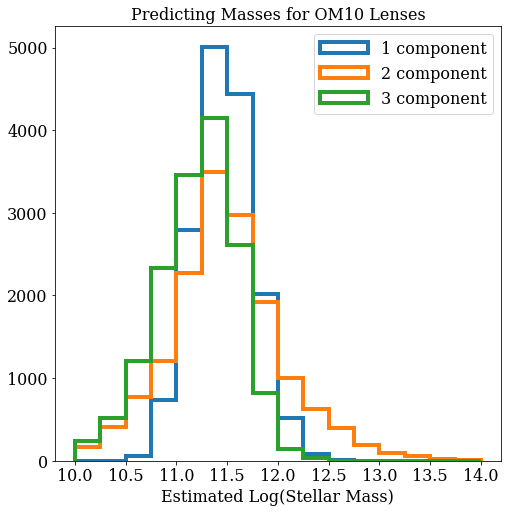

In [22]:
fig = plt.figure(figsize=(8,8))
mpl.rcParams['text.usetex'] = False
n, bins, _ = plt.hist(twinkles_log_m_1comp, histtype='step', label='1 component', range=(10, 14), lw=4, bins=16)
plt.hist(twinkles_log_m_2comp, histtype='step', label='2 component', bins=bins, lw=4)
plt.hist(twinkles_log_m_3comp, histtype='step', label='3 component', bins=bins, lw=4)
plt.xlabel('Estimated Log(Stellar Mass)')
plt.title('Predicting Masses for OM10 Lenses')
plt.legend()

Now we connect to the cosmoDC2 database and use redshift, stellar_mass and ellipticity of our OM10 galaxies to find associated radial sizes for our galaxies. The query looks for any galaxies within 10% in dex of redshift and 10% of stellar mass and ellipticity. For our lens galaxies we don't want disks. However, limiting ourselves in cosmoDC2 to only galaxies with `stellar_mass_disk` == 0.0 was too restrictive and we instead take the bulge properties for galaxies where the stellar mass of the bulge is over 99% of the total stellar mass. If no matches are found then it will skip on to the next system and we will leave that OM10 system out of the catalog available to the sprinkler.

In [23]:
import GCRCatalogs
import pandas as pd
from GCR import GCRQuery

In [24]:
catalog = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

In [25]:
# Predict a mass for each galaxy:
np.random.seed(0)
cond_indices = np.array([0,1])
twinkles_log_m_1comp = np.array([])

model_file='demo_model.fit'
empiricist.fit_model(X, Xerr, filename = 'demo_model.fit', n_components=1)
twinkles_data = np.array([twinkles_lenses['ZLENS'], twinkles_lenses['VELDISP']]).T

for x in twinkles_data:
    log_m = get_log_m(cond_indices, 2, x[cond_indices], model_file)
    twinkles_log_m_1comp = np.append(twinkles_log_m_1comp,log_m)

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.

In [26]:
%%time
gcr_om10_match = []
err = 0
np.random.seed(10)
i = 0

z_cat_min = np.power(10, np.log10(np.min(twinkles_lenses['ZLENS'])) - .1)
z_cat_max = np.power(10, np.log10(np.max(twinkles_lenses['ZLENS'])) + .1)

stellar_mass_cat_min = np.min(np.power(10, twinkles_log_m_1comp))*0.9
stellar_mass_cat_max = np.max(np.power(10, twinkles_log_m_1comp))*1.1

data = catalog.get_quantities(['galaxy_id', 'redshift_true', 'stellar_mass', 'ellipticity_true', 'size_true', 'size_minor_true', 
                               'stellar_mass_bulge', 'stellar_mass_disk', 'size_bulge_true', 'size_minor_bulge_true'],
                              filters=['stellar_mass > %f' % stellar_mass_cat_min, 'stellar_mass < %f' % stellar_mass_cat_max,
                                       'redshift_true > %f' % z_cat_min, 'redshift_true < %f' % z_cat_max,
                                       'stellar_mass_bulge/stellar_mass > 0.99'])

#### Important Note
# Twinkles issue #310 (https://github.com/LSSTDESC/Twinkles/issues/310) says OM10 defines ellipticity as 1 - b/a but
# gcr_catalogs defines ellipticity as (1-b/a)/(1+b/a) (https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md)

data['om10_ellipticity'] = (1-(data['size_minor_bulge_true']/data['size_bulge_true']))

data_df = pd.DataFrame(data)
print(data_df.head(10))

row_num = -1
keep_rows = []

for zsrc, m_star, ellip in zip(twinkles_lenses['ZLENS'], np.power(10, twinkles_log_m_1comp), twinkles_lenses['ELLIP']):

    row_num += 1
    #print(zsrc, m_star, ellip)
    if row_num % 1000 == 0:
        print(row_num)

    z_min, z_max = np.power(10, np.log10(zsrc) - .1), np.power(10, np.log10(zsrc) + .1)
    m_star_min, m_star_max = m_star*.9, m_star*1.1
    ellip_min, ellip_max = ellip*.9, ellip*1.1
    
    data_subset = data_df.query('redshift_true > %f and redshift_true < %f and stellar_mass > %f and stellar_mass < %f and om10_ellipticity > %f and om10_ellipticity < %f' %
                                (z_min, z_max, m_star_min, m_star_max, ellip_min, ellip_max))
    
    #data = catalog.get_quantities(['redshift_true', 'stellar_mass', 'ellipticity_true'])
    #data_subset = (query).filter(data)
    #print(data_subset)
    num_matches = len(data_subset['redshift_true'])
        
    if num_matches == 0:
        err += 1
        continue
    elif num_matches == 1:
        gcr_data = [data_subset['redshift_true'].values[0], 
                    data_subset['stellar_mass_bulge'].values[0],
                    data_subset['om10_ellipticity'].values[0],
                    data_subset['size_bulge_true'].values[0],
                    data_subset['size_minor_bulge_true'].values[0],
                    data_subset['galaxy_id'].values[0]]
        gcr_om10_match.append(gcr_data)
        keep_rows.append(row_num)
    elif num_matches > 1:
        use_idx = np.random.choice(num_matches)
        gcr_data = [data_subset['redshift_true'].values[use_idx], 
                    data_subset['stellar_mass_bulge'].values[use_idx],
                    data_subset['om10_ellipticity'].values[use_idx],
                    data_subset['size_bulge_true'].values[use_idx],
                    data_subset['size_minor_bulge_true'].values[use_idx],
                    data_subset['galaxy_id'].values[use_idx]]
        gcr_om10_match.append(gcr_data)
        keep_rows.append(row_num)
        
print("Total Match Failures: ", err, " Percentage Match Failures: ", np.float(err)/len(twinkles_log_m_1comp))

   ellipticity_true   galaxy_id  om10_ellipticity  redshift_true  \
0          0.140757  9437500130          0.246680       0.048067   
1          0.012475  9437500210          0.024502       0.048038   
2          0.146898  9437500219          0.255069       0.048258   
3          0.067933  9437500297          0.126787       0.043682   
4          0.071904  9437500798          0.134114       0.065674   
5          0.029170  9437500822          0.056686       0.050513   
6          0.210374  9437500837          0.347618       0.065573   
7          0.001369  9437500845          0.002738       0.052035   
8          0.060885  9437500936          0.113708       0.064737   
9          0.244887  9437502172          0.393428       0.088090   

   size_bulge_true  size_minor_bulge_true  size_minor_true  size_true  \
0         3.501384               2.637661         2.639362   3.504099   
1         5.027509               4.904325         4.908742   5.032767   
2         2.844191              

In [27]:
gcr_z_1comp = []
gcr_m_star_1comp = []
gcr_r_eff_1comp = []
gcr_gal_id_1comp = []
for row in gcr_om10_match:
    gcr_z_1comp.append(row[0])
    gcr_m_star_1comp.append(row[1])
    gcr_r_eff_1comp.append(np.sqrt(row[3]*row[4]))
    gcr_gal_id_1comp.append(row[5])

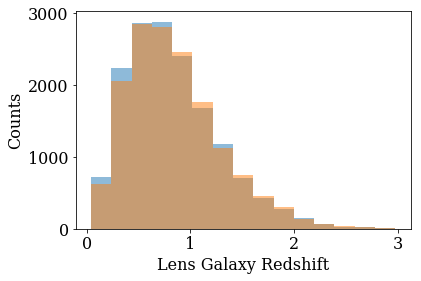

In [28]:
#Let's take a look at a couple results
n, bins, p = plt.hist(twinkles_lenses['ZLENS'], alpha=0.5, bins=15)
plt.hist(gcr_z_1comp, alpha=0.5, bins=bins)
plt.xlabel('Lens Galaxy Redshift')
plt.ylabel('Counts')

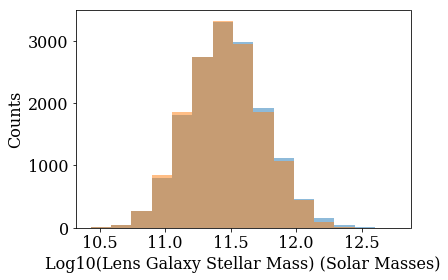

In [29]:
#Let's take a look at a couple results
n, bins, p = plt.hist(twinkles_log_m_1comp, alpha=0.5, bins=15)#, range=(0,100))
plt.hist(np.log10(gcr_m_star_1comp), alpha=0.5, bins=bins)
plt.xlabel('Log10(Lens Galaxy Stellar Mass) (Solar Masses)')
plt.ylabel('Counts')

We are able to match over 96% of the systems, but it seems that this disproportionately leaves out very high masses. Let's see if the 3-component model can do better.

In [30]:
# Predict a mass for each galaxy:
np.random.seed(0)
cond_indices = np.array([0,1])
twinkles_log_m = np.array([])
twinkles_reff = np.array([])

model_file='demo_model.fit'
empiricist.fit_model(X, Xerr, filename = 'demo_model.fit', n_components=3)
twinkles_data = np.array([twinkles_lenses['ZLENS'], twinkles_lenses['VELDISP']]).T

for x in twinkles_data:
    log_m = get_log_m(cond_indices, 2, x[cond_indices], model_file)
    twinkles_log_m = np.append(twinkles_log_m,log_m)

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.

In [31]:
%%time
gcr_om10_match = []
err = 0
np.random.seed(10)
i = 0

z_cat_min = np.power(10, np.log10(np.min(twinkles_lenses['ZLENS'])) - .1)
z_cat_max = np.power(10, np.log10(np.max(twinkles_lenses['ZLENS'])) + .1)

stellar_mass_cat_min = np.min(np.power(10, twinkles_log_m))*0.9
stellar_mass_cat_max = np.max(np.power(10, twinkles_log_m))*1.1

data = catalog.get_quantities(['galaxy_id', 'redshift_true', 'stellar_mass', 'ellipticity_true', 'size_true', 'size_minor_true', 
                               'stellar_mass_bulge', 'stellar_mass_disk', 'size_bulge_true', 'size_minor_bulge_true'],
                              filters=['stellar_mass > %f' % stellar_mass_cat_min, 'stellar_mass < %f' % stellar_mass_cat_max,
                                       'redshift_true > %f' % z_cat_min, 'redshift_true < %f' % z_cat_max,
                                       'stellar_mass_bulge/stellar_mass > 0.99'])

#### Important Note
# Twinkles issue #310 (https://github.com/LSSTDESC/Twinkles/issues/310) says OM10 defines ellipticity as 1 - b/a but
# gcr_catalogs defines ellipticity as (1-b/a)/(1+b/a) (https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md)

data['om10_ellipticity'] = (1-(data['size_minor_bulge_true']/data['size_bulge_true']))

data_df = pd.DataFrame(data)
print(data_df.head(10))

row_num = -1
keep_rows = []

for zsrc, m_star, ellip in zip(twinkles_lenses['ZLENS'], np.power(10, twinkles_log_m), twinkles_lenses['ELLIP']):

    row_num += 1
    #print(zsrc, m_star, ellip)
    if row_num % 1000 == 0:
        print(row_num)

    z_min, z_max = np.power(10, np.log10(zsrc) - .1), np.power(10, np.log10(zsrc) + .1)
    m_star_min, m_star_max = m_star*.9, m_star*1.1
    ellip_min, ellip_max = ellip*.9, ellip*1.1
    
    data_subset = data_df.query('redshift_true > %f and redshift_true < %f and stellar_mass > %f and stellar_mass < %f and om10_ellipticity > %f and om10_ellipticity < %f' %
                                (z_min, z_max, m_star_min, m_star_max, ellip_min, ellip_max))
    
    #data = catalog.get_quantities(['redshift_true', 'stellar_mass', 'ellipticity_true'])
    #data_subset = (query).filter(data)
    #print(data_subset)
    num_matches = len(data_subset['redshift_true'])
        
    if num_matches == 0:
        err += 1
        continue
    elif num_matches == 1:
        gcr_data = [data_subset['redshift_true'].values[0], 
                    data_subset['stellar_mass_bulge'].values[0],
                    data_subset['om10_ellipticity'].values[0],
                    data_subset['size_bulge_true'].values[0],
                    data_subset['size_minor_bulge_true'].values[0],
                    data_subset['galaxy_id'].values[0]]
        gcr_om10_match.append(gcr_data)
        keep_rows.append(row_num)
    elif num_matches > 1:
        use_idx = np.random.choice(num_matches)
        gcr_data = [data_subset['redshift_true'].values[use_idx], 
                    data_subset['stellar_mass_bulge'].values[use_idx],
                    data_subset['om10_ellipticity'].values[use_idx],
                    data_subset['size_bulge_true'].values[use_idx],
                    data_subset['size_minor_bulge_true'].values[use_idx],
                    data_subset['galaxy_id'].values[use_idx]]
        gcr_om10_match.append(gcr_data)
        keep_rows.append(row_num)
        
print("Total Match Failures: ", err, " Percentage Match Failures: ", np.float(err)/len(twinkles_log_m))

   ellipticity_true   galaxy_id  om10_ellipticity  redshift_true  \
0          0.140757  9437500130          0.246680       0.048067   
1          0.021438  9437500206          0.041191       0.048038   
2          0.012475  9437500210          0.024502       0.048038   
3          0.146898  9437500219          0.255069       0.048258   
4          0.067933  9437500297          0.126787       0.043682   
5          0.003816  9437500787          0.006769       0.067930   
6          0.071904  9437500798          0.134114       0.065674   
7          0.029170  9437500822          0.056686       0.050513   
8          0.210374  9437500837          0.347618       0.065573   
9          0.001369  9437500845          0.002738       0.052035   

   size_bulge_true  size_minor_bulge_true  size_minor_true  size_true  \
0         3.501384               2.637661         2.639362   3.504099   
1         1.437952               1.378722         1.380006   1.440472   
2         5.027509              

In [32]:
gcr_z = []
gcr_m_star = []
for row in gcr_om10_match:
    gcr_z.append(row[0])
    gcr_m_star.append(row[1])

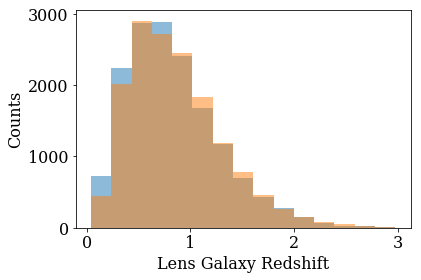

In [33]:
#Let's take a look at a couple results
n, bins, p = plt.hist(twinkles_lenses['ZLENS'], alpha=0.5, bins=15)
plt.hist(gcr_z, alpha=0.5, bins=bins)
plt.xlabel('Lens Galaxy Redshift')
plt.ylabel('Counts')

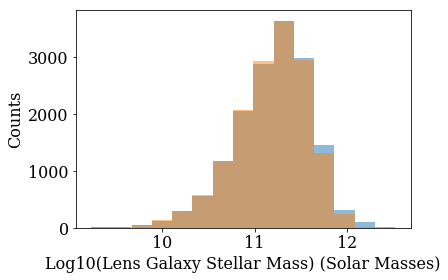

In [34]:
#Let's take a look at a couple results
n, bins, p = plt.hist(twinkles_log_m, alpha=0.5, bins=15)#, range=(0,100))
plt.hist(np.log10(gcr_m_star), alpha=0.5, bins=bins)
plt.xlabel('Log10(Lens Galaxy Stellar Mass) (Solar Masses)')
plt.ylabel('Counts')

The matching is now available in over 97% of the OM10 catalog but overall doesn't seem to make much of a difference at the high mass end. Since the distribution for the 3 component model seems to be unrealistic and doesn't add much improvement let's see if we can get a reasonable improvement on the 1 component results using a 2 component model.

In [35]:
# Predict a mass for each galaxy:
np.random.seed(0)
cond_indices = np.array([0,1])
twinkles_log_m = np.array([])
twinkles_reff = np.array([])

model_file='demo_model.fit'
empiricist.fit_model(X, Xerr, filename = 'demo_model.fit', n_components=2)
twinkles_data = np.array([twinkles_lenses['ZLENS'], twinkles_lenses['VELDISP']]).T

for x in twinkles_data:
    log_m = get_log_m(cond_indices, 2, x[cond_indices], model_file)
    twinkles_log_m = np.append(twinkles_log_m,log_m)

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.

In [36]:
%%time
gcr_om10_match = []
err = 0
np.random.seed(10)
i = 0

z_cat_min = np.power(10, np.log10(np.min(twinkles_lenses['ZLENS'])) - .1)
z_cat_max = np.power(10, np.log10(np.max(twinkles_lenses['ZLENS'])) + .1)

stellar_mass_cat_min = np.min(np.power(10, twinkles_log_m))*0.9
stellar_mass_cat_max = np.max(np.power(10, twinkles_log_m))*1.1

data = catalog.get_quantities(['galaxy_id', 'redshift_true', 'stellar_mass', 'ellipticity_true', 'size_true', 'size_minor_true', 
                               'stellar_mass_bulge', 'stellar_mass_disk', 'size_bulge_true', 'size_minor_bulge_true'],
                              filters=['stellar_mass > %f' % stellar_mass_cat_min, 'stellar_mass < %f' % stellar_mass_cat_max,
                                       'redshift_true > %f' % z_cat_min, 'redshift_true < %f' % z_cat_max,
                                       'stellar_mass_bulge/stellar_mass > 0.99'])

#### Important Note
# Twinkles issue #310 (https://github.com/LSSTDESC/Twinkles/issues/310) says OM10 defines ellipticity as 1 - b/a but
# gcr_catalogs defines ellipticity as (1-b/a)/(1+b/a) (https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md)

data['om10_ellipticity'] = (1-(data['size_minor_bulge_true']/data['size_bulge_true']))

data_df = pd.DataFrame(data)
print(data_df.head(10))

row_num = -1
keep_rows = []

for zsrc, m_star, ellip in zip(twinkles_lenses['ZLENS'], np.power(10, twinkles_log_m), twinkles_lenses['ELLIP']):

    row_num += 1
    #print(zsrc, m_star, ellip)
    if row_num % 1000 == 0:
        print(row_num)

    z_min, z_max = np.power(10, np.log10(zsrc) - .1), np.power(10, np.log10(zsrc) + .1)
    m_star_min, m_star_max = m_star*.9, m_star*1.1
    ellip_min, ellip_max = ellip*.9, ellip*1.1
    
    data_subset = data_df.query('redshift_true > %f and redshift_true < %f and stellar_mass > %f and stellar_mass < %f and om10_ellipticity > %f and om10_ellipticity < %f' %
                                (z_min, z_max, m_star_min, m_star_max, ellip_min, ellip_max))
    
    #data = catalog.get_quantities(['redshift_true', 'stellar_mass', 'ellipticity_true'])
    #data_subset = (query).filter(data)
    #print(data_subset)
    num_matches = len(data_subset['redshift_true'])
        
    if num_matches == 0:
        err += 1
        continue
    elif num_matches == 1:
        gcr_data = [data_subset['redshift_true'].values[0], 
                    data_subset['stellar_mass_bulge'].values[0],
                    data_subset['om10_ellipticity'].values[0],
                    data_subset['size_bulge_true'].values[0],
                    data_subset['size_minor_bulge_true'].values[0],
                    data_subset['galaxy_id'].values[0]]
        gcr_om10_match.append(gcr_data)
        keep_rows.append(row_num)
    elif num_matches > 1:
        use_idx = np.random.choice(num_matches)
        gcr_data = [data_subset['redshift_true'].values[use_idx], 
                    data_subset['stellar_mass_bulge'].values[use_idx],
                    data_subset['om10_ellipticity'].values[use_idx],
                    data_subset['size_bulge_true'].values[use_idx],
                    data_subset['size_minor_bulge_true'].values[use_idx],
                    data_subset['galaxy_id'].values[use_idx]]
        gcr_om10_match.append(gcr_data)
        keep_rows.append(row_num)
        
print("Total Match Failures: ", err, " Percentage Match Failures: ", np.float(err)/len(twinkles_log_m))

   ellipticity_true   galaxy_id  om10_ellipticity  redshift_true  \
0          0.140757  9437500130          0.246680       0.048067   
1          0.021438  9437500206          0.041191       0.048038   
2          0.012475  9437500210          0.024502       0.048038   
3          0.146898  9437500219          0.255069       0.048258   
4          0.067933  9437500297          0.126787       0.043682   
5          0.071904  9437500798          0.134114       0.065674   
6          0.029170  9437500822          0.056686       0.050513   
7          0.210374  9437500837          0.347618       0.065573   
8          0.001369  9437500845          0.002738       0.052035   
9          0.060885  9437500936          0.113708       0.064737   

   size_bulge_true  size_minor_bulge_true  size_minor_true  size_true  \
0         3.501384               2.637661         2.639362   3.504099   
1         1.437952               1.378722         1.380006   1.440472   
2         5.027509              

In [37]:
gcr_z = []
gcr_m_star = []
gcr_r_eff = []
gcr_gal_id = []
for row in gcr_om10_match:
    gcr_z.append(row[0])
    gcr_m_star.append(row[1])
    gcr_r_eff.append(np.sqrt(row[3]*row[4]))
    gcr_gal_id.append(row[5])

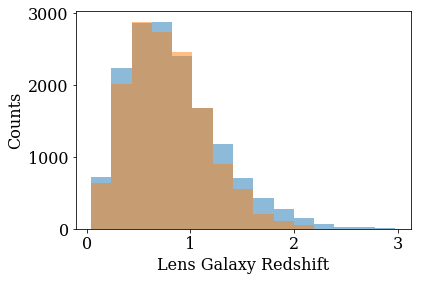

In [38]:
#Let's take a look at a couple results
n, bins, p = plt.hist(twinkles_lenses['ZLENS'], alpha=0.5, bins=15)
plt.hist(gcr_z, alpha=0.5, bins=bins)
plt.xlabel('Lens Galaxy Redshift')
plt.ylabel('Counts')

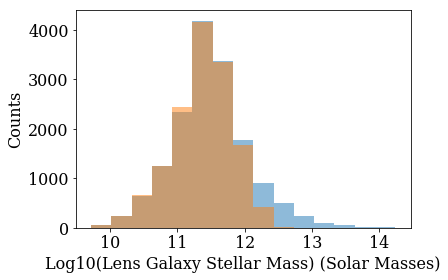

In [39]:
#Let's take a look at a couple results
n, bins, p = plt.hist(twinkles_log_m, alpha=0.5, bins=15)#, range=(0,100))
plt.hist(np.log10(gcr_m_star), alpha=0.5, bins=bins)
plt.xlabel('Log10(Lens Galaxy Stellar Mass) (Solar Masses)')
plt.ylabel('Counts')

This does the worst of the 3 models. Therefore, it looks like we should use the **1-component** model for the final match to the catalog.

## Matching to SEDs using `sims_GCRCatSimInterface`

The other thing we want to add into the lensing catalogs are SEDs for the lens galaxies. Here we get the top hat filters out of cosmoDC2 and use the code in `sims_GCRCatSimInterface` to match these values to a CATSIM SED file in the same way the galaxies are matched for Instance Catalog production in DC2. We also use the code to calculate the magnitude normalization for PhoSim.

In [40]:
from desc.sims.GCRCatSimInterface import sed_from_galacticus_mags

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.26_sim2.9.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sims_catalogs/2.9.0.sims/python/lsst/sims/catalogs/db/dbConnection.py:553: UserWarning: Duplicate object type id 4 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.26_sim2.9.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sims_catalogs/2.9.0.sims/python/lsst/sims/catalogs/db/dbConnection.py:553: UserWarning: Duplicate object type id 28 specified: 
Out

In [41]:
H0 = catalog.cosmology.H0.value
Om0 = catalog.cosmology.Om0

In [42]:
sed_label = []
sed_min_wave = []
sed_wave_width = []
for quant_label in sorted(catalog.list_all_quantities()):
    if (quant_label.startswith('sed') and quant_label.endswith('bulge')):
        sed_label.append(quant_label)
        label_split = quant_label.split('_')
        sed_min_wave.append(int(label_split[1])/10)
        sed_wave_width.append(int(label_split[2])/10)
bin_order = np.argsort(sed_min_wave)
sed_label = np.array(sed_label)[bin_order]
sed_min_wave = np.array(sed_min_wave)[bin_order]
sed_wave_width = np.array(sed_wave_width)[bin_order]

Check to see that our bins are now in order when we call them.

In [43]:
for i in zip(sed_label, sed_min_wave, sed_wave_width):
    print(i)

('sed_1000_246_bulge', 100.0, 24.600000000000001)
('sed_1246_306_bulge', 124.59999999999999, 30.600000000000001)
('sed_1552_381_bulge', 155.19999999999999, 38.100000000000001)
('sed_1933_474_bulge', 193.30000000000001, 47.399999999999999)
('sed_2407_591_bulge', 240.69999999999999, 59.100000000000001)
('sed_2998_186_bulge', 299.80000000000001, 18.600000000000001)
('sed_3184_197_bulge', 318.39999999999998, 19.699999999999999)
('sed_3381_209_bulge', 338.10000000000002, 20.899999999999999)
('sed_3590_222_bulge', 359.0, 22.199999999999999)
('sed_3812_236_bulge', 381.19999999999999, 23.600000000000001)
('sed_4048_251_bulge', 404.80000000000001, 25.100000000000001)
('sed_4299_266_bulge', 429.89999999999998, 26.600000000000001)
('sed_4565_283_bulge', 456.5, 28.300000000000001)
('sed_4848_300_bulge', 484.80000000000001, 30.0)
('sed_5148_319_bulge', 514.79999999999995, 31.899999999999999)
('sed_5467_339_bulge', 546.70000000000005, 33.899999999999999)
('sed_5806_360_bulge', 580.60000000000002, 36

In [44]:
del(data)
del(data_df)

In [45]:
columns = ['galaxy_id', 'redshift_true']
for sed_bin in sed_label:
    columns.append(sed_bin)
data = catalog.get_quantities(columns,
                              filters=['stellar_mass > %f' % stellar_mass_cat_min, 'stellar_mass < %f' % stellar_mass_cat_max,
                                       'redshift_true > %f' % z_cat_min, 'redshift_true < %f' % z_cat_max,
                                       'stellar_mass_bulge/stellar_mass > 0.99'])
data_df = pd.DataFrame(data)

In [46]:
%%time
sed_name_list = []
magNorm_list = []
i = 0
# Using 1-component model results
for gal_id, gal_z in zip(gcr_gal_id_1comp, gcr_z_1comp):
    
    if i % 1000 == 0:
        print(i)
    i+=1
    
    data_subset = data_df.query(str('galaxy_id == %i' % gal_id + ' and ' + 'redshift_true == {}'.format(gal_z))) ## Galaxy Ids are not unique in cosmoDC2_v0.1
    mag_array = []
    for sed_bin in sed_label:
        mag_array.append(-2.5*np.log10(data_subset[sed_bin].values[0]))
    mag_array = np.array(mag_array)
    sed_name, magNorm = sed_from_galacticus_mags(np.array([mag_array]).T, np.array([gal_z]), H0, Om0, sed_min_wave, sed_wave_width)
    sed_name_list.append(sed_name)
    magNorm_list.append(magNorm)
print(len(sed_name_list), len(keep_rows))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
15503 14240
CPU times: user 29min 32s, sys: 17.1 s, total: 29min 49s
Wall time: 21min 47s


In [47]:
sed_name_array = np.array(sed_name_list)
magNorm_array = np.array(magNorm_list)

Before saving our new information we want to check that the SEDs we are matching are in fact old, metal-poor templates. So we take the metallicity and age from all the templates and check them out.

In [48]:
sed_metals = []
sed_ages = []
sed_metals_dict = {'0005Z':'.005', '002Z':'.02', '02Z':'.2', '04Z':'.4', '1Z':'1.0', '25Z':'2.5'}
for sed_template in sed_name_array:
    sed_info = sed_template[0].split('/')[1].split('.')
    sed_age_info = sed_info[1].split('E')
    sed_ages.append(np.power(10, int(sed_age_info[1]))*int(sed_age_info[0]))
    sed_metals.append(sed_metals_dict[sed_info[2]])

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


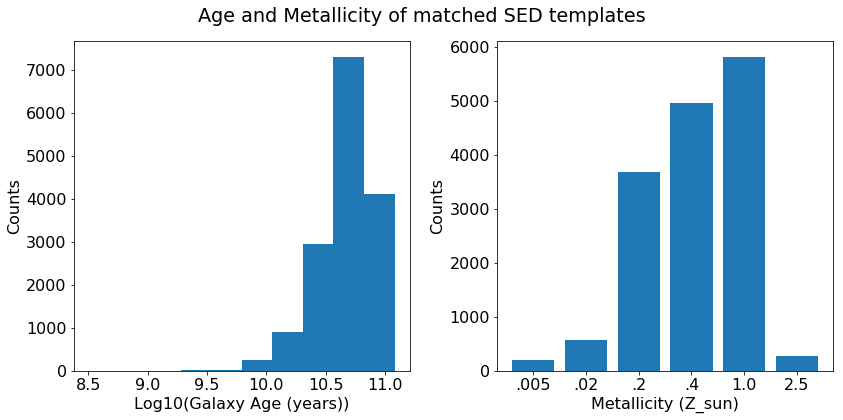

In [49]:
fig = plt.figure(figsize=(12, 6))
mpl.rcParams['text.usetex'] = False
fig.add_subplot(1,2,1)
plt.hist(np.log10(sed_ages))
plt.xlabel('Log10(Galaxy Age (years))')
plt.ylabel('Counts')
fig.add_subplot(1,2,2)
names, counts = np.unique(sed_metals, return_counts=True)
x = np.arange(len(names), dtype=int)
plt.bar(x, counts)
plt.xticks(x, names)
plt.xlabel('Metallicity (Z_sun)')
plt.ylabel('Counts')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle('Age and Metallicity of matched SED templates')

It seems that we are indeed getting templates for older galaxies and mostly less than solar metallicity.

## Adding new info to Twinkles OM10 data

We will take all the columns currently in the twinkles om10 data and add in our new reff values, SED filenames and SED magnitude normalizations.

In [50]:
col_list = []
for col in twinkles_lenses.columns:
    if col.name != 'REFF':
        col_list.append(fits.Column(name=col.name, format=col.format, array=twinkles_lenses[col.name][keep_rows]))
    else:
        col_list.append(fits.Column(name=col.name, format=col.format, array=gcr_r_eff))
col_list.append(fits.Column(name='lens_sed', format='30A', array=sed_name_array))
col_list.append(fits.Column(name='sed_magNorm', format='D', array=magNorm_array))

In [51]:
cols = fits.ColDefs(col_list)

In [52]:
tbhdu = fits.BinTableHDU.from_columns(cols)

In [53]:
tbhdu.writeto('../../data/twinkles_lenses_cosmoDC2_v1.1.4.fits')

Great! Now that we have saved our new lens catalog we can open it up and make sure the data is where we want it.

In [54]:
hdulist_2 = fits.open('../../data/twinkles_lenses_cosmoDC2_v1.1.4.fits')

In [55]:
print(hdulist_2[1].data[0])
print(hdulist_2[1].data['REFF'][0], hdulist_2[1].data['lens_sed'][0], hdulist_2[1].data['sed_magNorm'][0])
print(gcr_r_eff_1comp[0], sed_name_list[0], magNorm_list[0])

(21703, 0, 2, 0.071999999999999995, 165.1962, 0.28639799999999999, 131.00210000000001, 0.068274810000000005, -174.4367, 1.1899999999999999, -0.48952630000000003, 0.23893, 22.550000000000001, 23.27365, 1.5535779999999999, array([-1.2262,  0.1993,  0.    ,  0.    ]), array([ 0.5434, -0.0743,  0.    ,  0.    ]), array([ 1.8811, -0.5135,  0.    ,  0.    ]), array([ 0.   ,  7.601,  0.   ,  0.   ]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), 282.91012599999999, 325.115814, -21.640720399999999, 15.9914694, 0.071999996900000002, 1708.45, 1569.97, 0.0, 8193.8999999999996, 0.0, 1.4483760595321655, 0.0, 'galaxySED/Inst.12E10.04Z.spec.', 15.964922961181095)
1.44837605953 galaxySED/Inst.12E10.04Z.spec. 15.9649229612
1.72774 ['galaxySED/Inst.12E10.04Z.spec.gz'] [ 15.96492296]


Looks good!